<a href="https://colab.research.google.com/github/exsantucho/AnalisisYCuracion/blob/master/Entregable_Parte_2_V00_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 1 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad. Además de ello, tuvieron que reducir el número de valores posibles para las variables categóricas utilizando información de dominio.

En el ejercicio 2 de la parte 1 del entregable imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.**


In [37]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import seaborn as sns
seaborn.set_context('talk')

In [38]:
# Acá deberían leer el conjunto de datos que ya tienen.
melb_df = pd.read_csv(
    'https://raw.githubusercontent.com/exsantucho/AnalisisYCuracion/master/melbourn_housing.csv')
melb_df.sample(5)

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Propertycount,price_airbnb
11615,Hadfield,3,h,550000.0,S,Eview,22/07/2017,3046.0,1.0,2.0,325.0,100.0,1950.0,Moreland,2606.0,69.033333
4408,Northcote,2,u,430000.0,PI,Nelson,15/10/2016,3070.0,1.0,1.0,0.0,NaN,1970.0,Darebin,11364.0,113.281690
6108,Surrey Hills,5,h,2100000.0,PI,Ray,16/07/2016,3127.0,2.0,2.0,1025.0,277.0,1915.0,Whitehorse,5457.0,86.411765
8617,Toorak,2,u,655000.0,S,Rodney,8/04/2017,3142.0,1.0,1.0,1816.0,105.0,1960.0,Stonnington,7217.0,244.500000
762,Bentleigh,2,t,670000.0,PI,Buxton,26/07/2016,3204.0,2.0,1.0,123.0,90.0,2007.0,Glen Eira,6795.0,114.612500


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


In [39]:
# Ejercicio 1.1.
melb_df_filt= melb_df.drop(['BuildingArea', 'YearBuilt'], axis=1)
melb_df_filt.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Postcode,Bathroom,Car,Landsize,CouncilArea,Propertycount,price_airbnb
0,Abbotsford,2,h,1480000.0,S,Biggin,3/12/2016,3067.0,1.0,1.0,202.0,Yarra,4019.0,130.624031
1,Abbotsford,2,h,1035000.0,S,Biggin,4/02/2016,3067.0,1.0,0.0,156.0,Yarra,4019.0,130.624031
2,Abbotsford,3,h,1465000.0,SP,Biggin,4/03/2017,3067.0,2.0,0.0,134.0,Yarra,4019.0,130.624031
3,Abbotsford,3,h,850000.0,PI,Biggin,4/03/2017,3067.0,2.0,1.0,94.0,Yarra,4019.0,130.624031
4,Abbotsford,4,h,1600000.0,VB,Nelson,4/06/2016,3067.0,1.0,2.0,120.0,Yarra,4019.0,130.624031


In [40]:
# # Ejercicio 1.2.
# from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Encoding-Opción 1: OneHotEncoding (var. cat.) + Escalado estándar (var. num.) 
melb_df_filt_cat = melb_df_filt.select_dtypes(include=['object', 'category'])
melb_df_filt_num = melb_df_filt.select_dtypes(include=['number'])

var_cat = melb_df_filt_cat.columns.tolist()
var_num = melb_df_filt_num.columns.tolist()

# Se descarta la variable 'Date'
melb_df_filt_cat = melb_df_filt_cat.drop(columns='Date')

melb_df_filt_cat.head()
melb_df_filt_num.head()

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) # StandarScaler hace z = (x - u) / s (remueve la media y escala para varianza unitaria). 
                                   # Eventualmente se puede definir otra posibilidad de escalado para otras columnas

transformador = ColumnTransformer(
    transformers=[
    ('cat', cat_transformer, var_cat),
    ('num', num_transformer, var_num)],
    sparse_threshold=0) # parámetro 0 indica que quiero obtener matriz densa. Si se quiere sparse, quitar este parámetro

## Otra manera de hacer lo mismo que lo anterior, pero más simple
# transformador = make_column_transformer(
#     (OneHotEncoder(),  var_cat),
#     (StandardScaler(), var_num), # StandarScaler hace z = (x - u) / s (remueve la media y escala para varianza unitaria)
#     sparse_threshold = 0, # parámetro 0 indica que quiero obtener matriz densa. Si se quiere sparse, quitar este parámetro
#     remainder='drop') # descarta las columnas no mencionadas en las transformaciones
## Aunque de esta manera se me dificulta acceder al nombre de las columnas del OHE.
## Es por eso que se decide hacer como se muestra a continuación.

# Entrenamiento del transformador
transformador.fit(melb_df_filt)

# Transformación del dataset
melb_df_filt_SCL_OHE = transformador.transform(melb_df_filt)
melb_df_filt_SCL_OHE # devuelve matriz numpy

var_cat_OHE = transformador.transformers_[0][1][0].get_feature_names() # los índices del método "transformers_" apuntan al OneHotEncoding del transformador.
                                                                       # [0][1][0] = [fila 0 de transformers][columna 1 de transformers (cat_transformer)][fila 0 de cat_transformer]
                                                                       # es lo mismo que hacer: transformador.named_transformers_['cat'].named_steps['onehot'].get_feature_names()

var_cat_OHE = var_cat_OHE.tolist()
# Escribo de manera más bonita las columnas provenientes de OHE
var_cat_OHE = []
for var_cat_name, var_cat_values in zip(var_cat, transformador.transformers_[0][1][0].categories_):
  for var_cat_value in var_cat_values:
    var_cat_OHE.append('{}={}'.format(var_cat_name, var_cat_value))

# Obtención de nuevas features (nombres de columnas)
columns_new = [*var_num, *var_cat_OHE] # merge de dos listas usando unpacking

# Se construye un nuevo dataframe
melb_df_filt_scl_ohe_new = pd.DataFrame(data=melb_df_filt_SCL_OHE, columns=columns_new)
melb_df_filt_scl_ohe_new.sample(3)
melb_df_filt_scl_ohe_new.describe()


,Rooms,Price,Postcode,Bathroom,Car,Landsize,Propertycount,price_airbnb,Suburb=Abbotsford,Suburb=Aberfeldie,Suburb=Airport West,Suburb=Albanvale,Suburb=Albert Park,Suburb=Albion,Suburb=Alphington,Suburb=Altona,Suburb=Altona Meadows,Suburb=Altona North,Suburb=Ardeer,Suburb=Armadale,Suburb=Ascot Vale,Suburb=Ashburton,Suburb=Ashwood,Suburb=Aspendale,Suburb=Aspendale Gardens,Suburb=Attwood,Suburb=Avondale Heights,Suburb=Bacchus Marsh,Suburb=Balaclava,Suburb=Balwyn,Suburb=Balwyn North,Suburb=Bayswater,Suburb=Bayswater North,Suburb=Beaconsfield,Suburb=Beaconsfield Upper,Suburb=Beaumaris,Suburb=Bellfield,Suburb=Bentleigh,Suburb=Bentleigh East,Suburb=Berwick,...,Date=6/08/2016,Date=7/05/2016,Date=7/11/2016,Date=8/04/2017,Date=8/07/2017,Date=8/10/2016,Date=9/09/2017,CouncilArea=Banyule,CouncilArea=Bayside,CouncilArea=Boroondara,CouncilArea=Brimbank,CouncilArea=Cardinia,CouncilArea=Casey,CouncilArea=Darebin,CouncilArea=Frankston,CouncilArea=Glen Eira,CouncilArea=Greater Dandenong,CouncilArea=Hobsons Bay,CouncilArea=Hume,CouncilArea=Kingston,CouncilArea=Knox,CouncilArea=Macedon Ranges,CouncilArea=Manningham,CouncilArea=Maribyrnong,CouncilArea=Maroondah,CouncilArea=Melbourne,CouncilArea=Melton,CouncilArea=Monash,CouncilArea=Moonee Valley,CouncilArea=Moorabool,CouncilArea=Moreland,CouncilArea=Nillumbik,CouncilArea=Port Phillip,CouncilArea=Stonnington,CouncilArea=Unavailable,CouncilArea=Whitehorse,CouncilArea=Whittlesea,CouncilArea=Wyndham,CouncilArea=Yarra,CouncilArea=Yarra Ranges
count,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,...,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.00000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,13433.000000,1.343300e+04,1.343300e+04,1.343300e+04,1.343300e+04,1.343300e+04,1.343300e+04,1.343300e+04,1.343300e+04
mean,0.004169,0.003201,0.004988,0.000447,0.004913,0.002978,0.002457,0.005509,0.000447,0.004169,0.000223,0.006774,0.009603,0.004467,0.003424,0.000521,0.000298,0.000074,0.005360,0.000074,0.001787,0.007668,0.012655,0.000968,0.000596,0.000149,0.000074,0.001340,0.001191,0.010348,0.018462,0.000893,0.000893,0.001563,0.001042,0.000893,0.000298,0.001042,0.004392,0.003424,...,0.035807,0.085610,0.031266,0.000596,0.002680,0.068860,0.003946,0.062830,0.003797,0.032234,0.012209,0.015335,0.005881,0.000521,0.023152,0.051292,0.005955,0.034542,0.004913,0.024641,0.073997,0.000074,0.18328,0.002680,0.046378,0.052632,0.000074,0.022556,0.012432,0.006402,0.048016,0.001340,-5.371089e-15,-1.659508e-16,-5.375156e-16,-1.591256e-15,-7.369135e-15,7.505535e-16,5.579340e-16,-2.649466e-16
std,0.064434,0.056489,0.070450,0.021130,0.069925,0.054489,0.049505,0.074019,0.021130,0.064434,0.014943,0.082030,0.097528,0.066686,0.058420,0.022823,0.017254,0.008628,0.073018,0.008628,0.042233,0.087232,0.111786,0.031095,0.024397,0.012201,0.008628,0.036583,0.034493,0.101200,0.134620,0.029876,0.029876,0.039509,0.032268,0.029876,0.017254,0.032268,0.066130,0.058420,...,0.185816,0.279798,0.174043,0.024397,0.051701,0.253226,0.062692,0.242667,0.061502,0.176628,0.109821,0.122887,0.076465,0.022823,0.150392,0.220600,0.076944,0.182623,0.069925,0.155034,0.261776,0.008628,0.38691,0.051701,0.210311,0.223305,0.008628,0.148490,0.110808,0.079760,0.213808,0.036583,1.000037e+00,1.000037e+00,1.000037e+00

In [41]:
# Encoding-Opción 2: DictVectorizer

# HACER SI HAY TIEMPO

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

In [42]:
# Ejercicio 2.1.

melb_df_full = pd.concat([melb_df_filt_scl_ohe_new, melb_df[['BuildingArea', 'YearBuilt']]], axis=1)
melb_df_full.head(3)

,Rooms,Price,Postcode,Bathroom,Car,Landsize,Propertycount,price_airbnb,Suburb=Abbotsford,Suburb=Aberfeldie,Suburb=Airport West,Suburb=Albanvale,Suburb=Albert Park,Suburb=Albion,Suburb=Alphington,Suburb=Altona,Suburb=Altona Meadows,Suburb=Altona North,Suburb=Ardeer,Suburb=Armadale,Suburb=Ascot Vale,Suburb=Ashburton,Suburb=Ashwood,Suburb=Aspendale,Suburb=Aspendale Gardens,Suburb=Attwood,Suburb=Avondale Heights,Suburb=Bacchus Marsh,Suburb=Balaclava,Suburb=Balwyn,Suburb=Balwyn North,Suburb=Bayswater,Suburb=Bayswater North,Suburb=Beaconsfield,Suburb=Beaconsfield Upper,Suburb=Beaumaris,Suburb=Bellfield,Suburb=Bentleigh,Suburb=Bentleigh East,Suburb=Berwick,...,Date=7/11/2016,Date=8/04/2017,Date=8/07/2017,Date=8/10/2016,Date=9/09/2017,CouncilArea=Banyule,CouncilArea=Bayside,CouncilArea=Boroondara,CouncilArea=Brimbank,CouncilArea=Cardinia,CouncilArea=Casey,CouncilArea=Darebin,CouncilArea=Frankston,CouncilArea=Glen Eira,CouncilArea=Greater Dandenong,CouncilArea=Hobsons Bay,CouncilArea=Hume,CouncilArea=Kingston,CouncilArea=Knox,CouncilArea=Macedon Ranges,CouncilArea=Manningham,CouncilArea=Maribyrnong,CouncilArea=Maroondah,CouncilArea=Melbourne,CouncilArea=Melton,CouncilArea=Monash,CouncilArea=Moonee Valley,CouncilArea=Moorabool,CouncilArea=Moreland,CouncilArea=Nillumbik,CouncilArea=Port Phillip,CouncilArea=Stonnington,CouncilArea=Unavailable,CouncilArea=Whitehorse,CouncilArea=Whittlesea,CouncilArea=Wyndham,CouncilArea=Yarra,CouncilArea=Yarra Ranges,BuildingArea,YearBuilt
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.986093,0.638541,-0.420983,-0.791113,-0.651860,-0.088858,-0.783351,-0.036592,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.986093,-0.059905,-0.420983,-0.791113,-1.731969,-0.100328,-0.783351,-0.036592,79.0,1900.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.063442,0.614998,-0.420983,0.692901,-1.731969,-0.105814,-0.783351,-0.036592,150.0,1900.0


In [43]:
# Ejercicio 2.2.
# Los imputadores a comparar son:
# a) Iterative Imputer con KNN utilizando sólo las columnas [['YearBuilt','BuildingArea']].
# b) Iterative Imputer con KNN utilizando todas las columnas de la matriz.

from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

# Alternativa a) 

#-----------------
melb_df_mice_a = melb_df.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_df_mice_a[['BuildingArea', 'YearBuilt']] = mice_imputer.fit_transform(
    melb_df_mice_a[['BuildingArea', 'YearBuilt']])

melb_df_mice_a.head()
#-----------------
#-----------------
# melb_df_mice_a = melb_df_full.copy(deep=True)

# mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
# melb_df_mice_a[['BuildingArea', 'YearBuilt']] = mice_imputer.fit_transform(
#     melb_df_mice_a[['BuildingArea', 'YearBuilt']])

# melb_df_mice_a.head()
#-----------------

# Se debe redondear valores de YearBuilts?
# DUDA SI SE DEBE CONSIDERAR LO COMENTADO O LO QUE ESTA EJECUTANDOSE

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,Suburb,Rooms,Type,Price,Method,SellerG,Date,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Propertycount,price_airbnb
0,Abbotsford,2,h,1480000.0,S,Biggin,3/12/2016,3067.0,1.0,1.0,202.0,270.4,1974.2,Yarra,4019.0,130.624031
1,Abbotsford,2,h,1035000.0,S,Biggin,4/02/2016,3067.0,1.0,0.0,156.0,79.0,1900.0,Yarra,4019.0,130.624031
2,Abbotsford,3,h,1465000.0,SP,Biggin,4/03/2017,3067.0,2.0,0.0,134.0,150.0,1900.0,Yarra,4019.0,130.624031
3,Abbotsford,3,h,850000.0,PI,Biggin,4/03/2017,3067.0,2.0,1.0,94.0,270.4,1974.2,Yarra,4019.0,130.624031
4,Abbotsford,4,h,1600000.0,VB,Nelson,4/06/2016,3067.0,1.0,2.0,120.0,142.0,2014.0,Yarra,4019.0,130.624031


In [44]:
# Alternativa b)
# Sí es necesario escalar las variables numéricas. Como se vio en celdas anteriores,
# se realizó un StadarScaler (Ejercicio 1.2.).

#-----------------
melb_df_mice_b = melb_df_full.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
melb_df_mice_b[['BuildingArea', 'YearBuilt']] = mice_imputer.fit_transform(
    melb_df_mice_b[['BuildingArea', 'YearBuilt']])

melb_df_mice_b.head()
#-----------------
#-----------------
# melb_df_mice_b = melb_df_full.copy(deep=True)

# mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())
# melb_df_mice_b[['BuildingArea', 'YearBuilt']] = mice_imputer.fit_transform(
#     melb_df_mice_b)

# melb_df_mice_b.head()
#-----------------

# Se debe redondear valores de YearBuilts?
# DUDA SI SE DEBE CONSIDERAR LO COMENTADO O LO QUE ESTA EJECUTANDOSE

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


,Rooms,Price,Postcode,Bathroom,Car,Landsize,Propertycount,price_airbnb,Suburb=Abbotsford,Suburb=Aberfeldie,Suburb=Airport West,Suburb=Albanvale,Suburb=Albert Park,Suburb=Albion,Suburb=Alphington,Suburb=Altona,Suburb=Altona Meadows,Suburb=Altona North,Suburb=Ardeer,Suburb=Armadale,Suburb=Ascot Vale,Suburb=Ashburton,Suburb=Ashwood,Suburb=Aspendale,Suburb=Aspendale Gardens,Suburb=Attwood,Suburb=Avondale Heights,Suburb=Bacchus Marsh,Suburb=Balaclava,Suburb=Balwyn,Suburb=Balwyn North,Suburb=Bayswater,Suburb=Bayswater North,Suburb=Beaconsfield,Suburb=Beaconsfield Upper,Suburb=Beaumaris,Suburb=Bellfield,Suburb=Bentleigh,Suburb=Bentleigh East,Suburb=Berwick,...,Date=7/11/2016,Date=8/04/2017,Date=8/07/2017,Date=8/10/2016,Date=9/09/2017,CouncilArea=Banyule,CouncilArea=Bayside,CouncilArea=Boroondara,CouncilArea=Brimbank,CouncilArea=Cardinia,CouncilArea=Casey,CouncilArea=Darebin,CouncilArea=Frankston,CouncilArea=Glen Eira,CouncilArea=Greater Dandenong,CouncilArea=Hobsons Bay,CouncilArea=Hume,CouncilArea=Kingston,CouncilArea=Knox,CouncilArea=Macedon Ranges,CouncilArea=Manningham,CouncilArea=Maribyrnong,CouncilArea=Maroondah,CouncilArea=Melbourne,CouncilArea=Melton,CouncilArea=Monash,CouncilArea=Moonee Valley,CouncilArea=Moorabool,CouncilArea=Moreland,CouncilArea=Nillumbik,CouncilArea=Port Phillip,CouncilArea=Stonnington,CouncilArea=Unavailable,CouncilArea=Whitehorse,CouncilArea=Whittlesea,CouncilArea=Wyndham,CouncilArea=Yarra,CouncilArea=Yarra Ranges,BuildingArea,YearBuilt
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.986093,0.638541,-0.420983,-0.791113,-0.651860,-0.088858,-0.783351,-0.036592,270.4,1974.2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.986093,-0.059905,-0.420983,-0.791113,-1.731969,-0.100328,-0.783351,-0.036592,79.0,1900.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.063442,0.614998,-0.420983,0.692901,-1.731969,-0.105814,-0.783351,-0.036592,150.0,1900.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.063442,-0.350270,-0.420983,0.692901,-0.651860,-0.115787,-0.783351,-0.036592,270.4,1974.2
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.112978,0.826886,-0.420983,-0.791113,0.428248,-0.109304,-0.783351,-0.036592,142.0,2014.0


Ejemplo de gráfico comparando las distribuciones de datos obtenidas con cada método de imputación.

In [36]:
# Ejercicio 2.3.
# Para variable 'YearBuilt'
melb_year_built_orig = melb_df.YearBuilt.dropna().to_frame()
melb_year_built_orig['Imputation'] = 'Original'

mice_year_built_a = melb_df_mice_a.YearBuilt.to_frame()
mice_year_built_a['Imputation'] = 'KNN over BuildingArea and YearBuilt'

mice_year_built_b = melb_df_mice_b.YearBuilt.to_frame()
mice_year_built_b['Imputation'] = 'KNN over all features'

data = pd.concat([melb_year_built_orig, mice_year_built_a, mice_year_built_b])
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(data=data, x='YearBuilt', hue='Imputation')
# plt.legend(bbox_to_anchor = (1, 1)) # loc = 'upper right')

# VER DE COMO ACOMODAR UBICACION DE LEGEND!!!!

,YearBuilt,Imputation
0,1974.2,KNN over all features
1,1900.0,KNN over all features
2,1900.0,KNN over all features
3,1974.2,KNN over all features
4,2014.0,KNN over all features
...,...,...
13428,1981.0,KNN over all features
13429,1995.0,KNN over all features
13430,1997.0,KNN over all features
13431,1920.0,KNN over all features


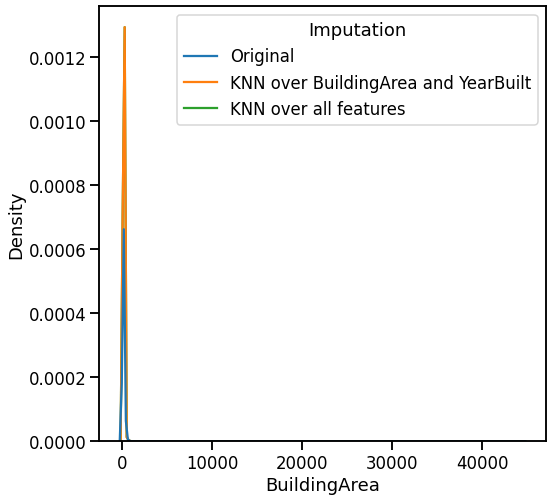

In [34]:
# Ejercicio 2.3.
# Para variable 'BuildingArea'
melb_building_area_orig = melb_df.BuildingArea.dropna().to_frame()
melb_building_area_orig['Imputation'] = 'Original'

mice_building_area_a = melb_df_mice_a.BuildingArea.to_frame()
mice_building_area_a['Imputation'] = 'KNN over BuildingArea and YearBuilt'

mice_building_area_b = melb_df_mice_b.BuildingArea.to_frame()
mice_building_area_b['Imputation'] = 'KNN over all features'

data = pd.concat([melb_building_area_orig, mice_building_area_a, mice_building_area_b])
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(data=data, x='BuildingArea', hue='Imputation')
# plt.legend(bbox_to_anchor = (1, 1)) # loc = 'upper right')

# VER DE COMO ACOMODAR UBICACION DE LEGEND!!!!

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

In [48]:
# Ejercicioo 3.1.
# Sí es necesario escalar las variables numéricas. Como se vio en celdas anteriores,
# se realizó un StandardScaler (Ejercicio 1.2.).

# Se vuelva a aplicar un StandardScaler para las variables BuildingArea y YearBuilt (son las que faltaban)
columns_to_scale=['BuildingArea', 'YearBuilt']
scaler=StandardScaler()
melb_df_mice_b[columns_to_scale] = scaler.fit_transform(melb_df_mice_b[columns_to_scale])
melb_df_mice_b.describe()

# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(melb_df_mice_b)
proyected_features = pca.transform(melb_df_mice_b)
proyected_features.shape

(13433, 20)

In [49]:
# Print de valor de varianza explicada con las 20 componentes principales
pca.explained_variance_ratio_

array([0.16646155, 0.0992685 , 0.08132535, 0.07432642, 0.0654383 ,
       0.06389915, 0.04937102, 0.03718186, 0.03167684, 0.02715326,
       0.01915989, 0.01262683, 0.01080123, 0.00814513, 0.0080253 ,
       0.0071839 , 0.00696648, 0.00624489, 0.00562928, 0.00517207])

Text(0.5, 0, 'Components')

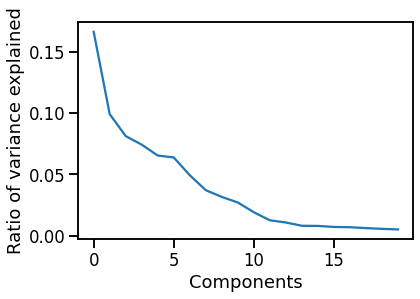

In [53]:
seaborn.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_)
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")

In [59]:
# Creo nombres automáticos para componentes principales según n° en PCA
pca_columns = ['pca_' + str(i) for i in range(1, pca.n_components+1)]

melb_df_mice_b[pca_columns] = proyected_features[:,:pca.n_components]
melb_df_mice_b[pca_columns].head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20
0,-0.790153,0.113579,0.686879,-0.638342,-0.046484,-0.435797,0.329641,0.540005,-0.797144,-0.788804,-0.218433,-0.439763,-0.421070,-0.075251,-0.069642,0.061620,-0.032135,0.038429,-0.077005,0.182253
1,-1.434590,-0.380609,2.886295,-0.273652,-0.019367,-0.678706,0.288613,-0.206870,0.225989,0.294385,-0.475134,-0.304718,-0.335192,-0.146356,-0.108356,0.061311,0.118316,0.049356,-0.062051,0.139780
2,0.195229,-0.560114,2.708093,-0.288801,-0.037050,-0.631825,1.193764,-0.422811,0.396362,1.024770,0.526400,-0.278721,-0.338401,0.253171,-0.727481,0.171292,-0.014770,-0.134779,-0.172518,0.179733
3,0.056366,0.031207,-0.017189,-0.844641,-0.095773,-0.338918,0.877988,-0.084636,0.362258,0.511316,0.554827,-0.371024,-0.503120,-0.540213,0.472193,0.110892,-0.058173,-0.214163,-0.257614,0.165938
4,0.708163,-0.183873,-0.827546,-1.092622,-0.043976,-0.072954,0.023067,0.144329,-0.319549,-1.544929,1.173521,0.217617,0.002474,0.755126,0.636982,-0.464151,0.043741,0.727221,-0.091770,0.160327


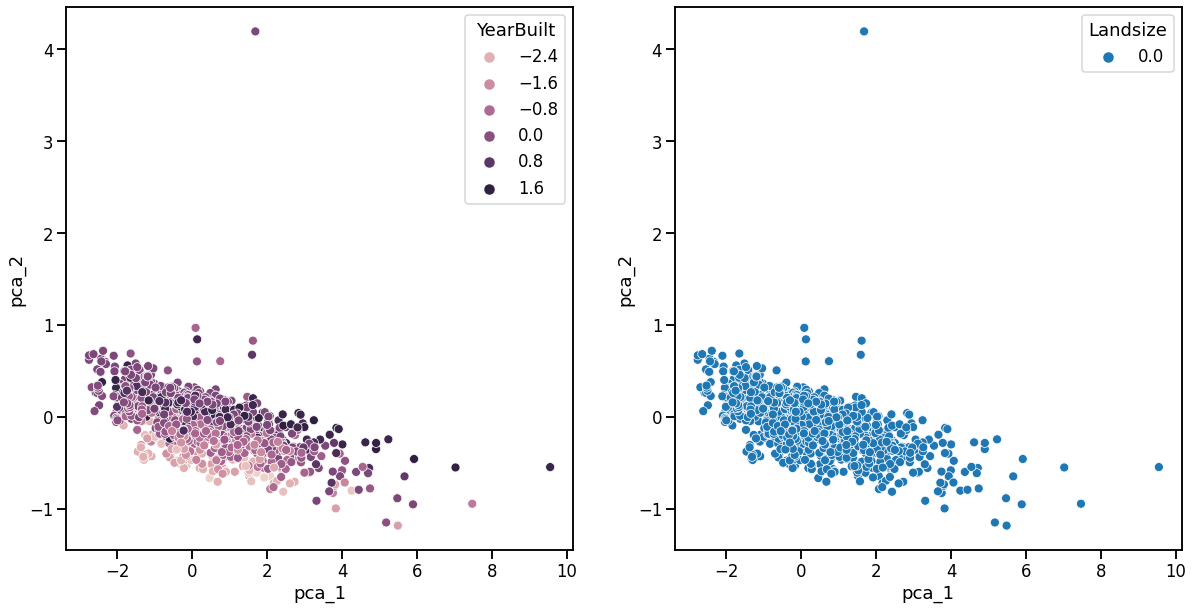

In [60]:
cols = ['YearBuilt', 'Landsize']
data = melb_df_mice_b[cols + ['pca_1', 'pca_2']][:1000].dropna(how='any')
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Other variables to try: 'Price' 'Landsize' 'Price' 'YearBuilt'
seaborn.scatterplot(data=data, x='pca_1', y='pca_2',
                    hue='YearBuilt', ax=axes[0])  
seaborn.scatterplot(data=data, x='pca_1', y='pca_2',
                    hue='Landsize', ax=axes[1])

# Qué se intanta mostrar en este gráfico????

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [61]:
# Esto ya se hizo anteriormente. El dataframe resultante es
melb_df_mice_b.sample(3)

,Rooms,Price,Postcode,Bathroom,Car,Landsize,Propertycount,price_airbnb,Suburb=Abbotsford,Suburb=Aberfeldie,Suburb=Airport West,Suburb=Albanvale,Suburb=Albert Park,Suburb=Albion,Suburb=Alphington,Suburb=Altona,Suburb=Altona Meadows,Suburb=Altona North,Suburb=Ardeer,Suburb=Armadale,Suburb=Ascot Vale,Suburb=Ashburton,Suburb=Ashwood,Suburb=Aspendale,Suburb=Aspendale Gardens,Suburb=Attwood,Suburb=Avondale Heights,Suburb=Bacchus Marsh,Suburb=Balaclava,Suburb=Balwyn,Suburb=Balwyn North,Suburb=Bayswater,Suburb=Bayswater North,Suburb=Beaconsfield,Suburb=Beaconsfield Upper,Suburb=Beaumaris,Suburb=Bellfield,Suburb=Bentleigh,Suburb=Bentleigh East,Suburb=Berwick,...,CouncilArea=Manningham,CouncilArea=Maribyrnong,CouncilArea=Maroondah,CouncilArea=Melbourne,CouncilArea=Melton,CouncilArea=Monash,CouncilArea=Moonee Valley,CouncilArea=Moorabool,CouncilArea=Moreland,CouncilArea=Nillumbik,CouncilArea=Port Phillip,CouncilArea=Stonnington,CouncilArea=Unavailable,CouncilArea=Whitehorse,CouncilArea=Whittlesea,CouncilArea=Wyndham,CouncilArea=Yarra,CouncilArea=Yarra Ranges,BuildingArea,YearBuilt,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20
4817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.986093,-0.256098,0.838881,-0.791113,-0.651860,-0.093596,0.060436,-0.035897,-0.313727,-1.346250,-1.104505,-0.104147,1.355499,0.902849,-0.164094,-0.741390,-0.523865,-0.030969,0.087348,0.097718,-0.396482,-0.316963,-0.327306,-0.129894,-0.037374,0.011660,0.026930,0.049094,0.062082,0.231166
10370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.986093,0.293242,-0.387829,-0.791113,-0.651860,-0.080879,0.892587,-0.037279,-0.105430,-2.395489,-0.951195,-0.378152,2.514595,0.922659,0.071565,0.788273,-0.361556,-0.025719,-0.199050,0.320868,-0.420678,-0.202843,-0.323345,-0.216454,-0.147699,-0.371312,0.451059,-0.208059,0.030803,0.441395
12768,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063442,-0.114839,-0.420983,-0.791113,0.428248,-0.090354,-0.783351,-0.036592,-0.105430,-2.395489,-0.011521,-0.370109,2.131486,-0.621814,-0.082836,-0.047571,-1.354159,-0.144795,0.446956,0.714579,0.729349,-0.371590,0.615674,-0.614583,0.449465,0.364048,-0.000473,-0.228790,0.017289,-0.031193


## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
